In [11]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional , CuDNNLSTM
import math
from sklearn.metrics import mean_squared_error
!pip install pandas-datareader
from pandas_datareader import data as pdr
!pip install fix-yahoo-finance
import fix_yahoo_finance as yf

In [19]:
share = 'SPY'
yf
dataset = yf.download(share,"2014-3-14") #, start="2017-01-01"
#dataset =data.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
dataset.head()


[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-14,184.850006,185.800003,184.440002,184.660004,167.238724,153919600
2014-03-17,185.589996,186.770004,185.509995,186.330002,168.751160,98359500
2014-03-18,186.710007,187.910004,186.509995,187.660004,169.955658,101804600
2014-03-19,187.679993,187.940002,185.470001,186.660004,169.050003,176267300
2014-03-20,186.250000,187.889999,185.919998,187.750000,170.037186,117241000


In [20]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-13,275.029999,275.929993,274.559998,274.989990,274.989990,65277200
2019-02-14,273.779999,275.640015,272.869995,274.380005,274.380005,83234400
2019-02-15,276.359985,277.410004,276.130005,277.369995,277.369995,97088700
2019-02-19,276.480011,278.579987,276.470001,277.850006,277.850006,58877000
2019-02-20,277.809998,278.920013,277.250000,278.429993,278.429993,76610767


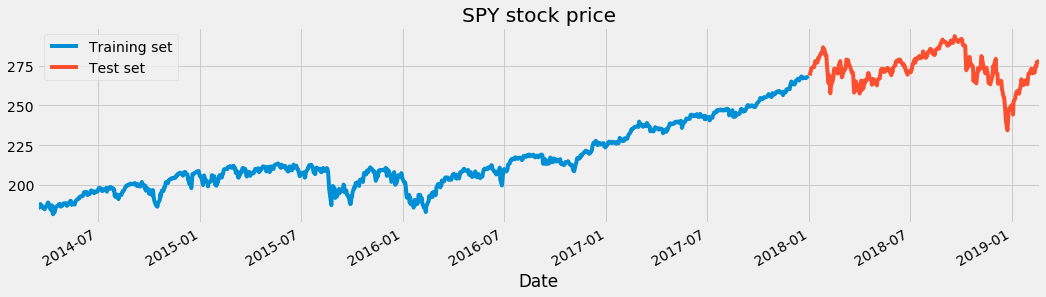

In [44]:

training_set = dataset['2014':'2017'].iloc[:,0:1].values  #2010 or 2012
test_set = dataset['2018':].iloc[:,0:1].values


dataset["Close"]['2014':'2017'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title(share+' stock price')
plt.show()

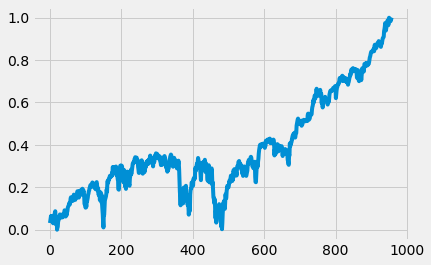

In [25]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

plt.plot(training_set_scaled)
plt.show()

In [27]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-previous:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [28]:
# Reshaping X_train for efficient modelling

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(928, 30, 1)

In [29]:
X_train

array([[[0.03136945],
        [0.03993514],
        [0.05289973],
        ...,
        [0.06574844],
        [0.07211478],
        [0.05880313]],

       [[0.03993514],
        [0.05289973],
        [0.06412772],
        ...,
        [0.07211478],
        [0.05880313],
        [0.05683533]],

       [[0.05289973],
        [0.06412772],
        [0.04757496],
        ...,
        [0.05880313],
        [0.05683533],
        [0.06181268]],

       ...,

       [[0.87012385],
        [0.87128146],
        [0.86213678],
        ...,
        [0.99085532],
        [0.98923495],
        [0.98286826]],

       [[0.87128146],
        [0.86213678],
        [0.87255458],
        ...,
        [0.98923495],
        [0.98286826],
        [0.98668834]],

       [[0.86213678],
        [0.87255458],
        [0.88065751],
        ...,
        [0.98286826],
        [0.98668834],
        [0.99259192]]])

In [31]:

# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
928/928 [==============================] - 7s 7ms/step - loss: 0.0326
Epoch 2/50
928/928 [==============================] - 4s 4ms/step - loss: 0.0051
Epoch 3/50
928/928 [==============================] - 4s 4ms/step - loss: 0.0041
Epoch 4/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0040
Epoch 5/50
928/928 [==============================] - 5s 5ms/step - loss: 0.0034
Epoch 6/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0031
Epoch 7/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0033
Epoch 8/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0031
Epoch 9/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0030
Epoch 10/50
928/928 [==============================] - 4s 4ms/step - loss: 0.0027
Epoch 11/50
928/928 [==============================] - 4s 4ms/step - loss: 0.0031
Epoch 12/50
928/928 [==============================] - 4s 5ms/step - loss: 0.0028
Epoch 13/50
928/928 [====

[277.809998] [274.6156]


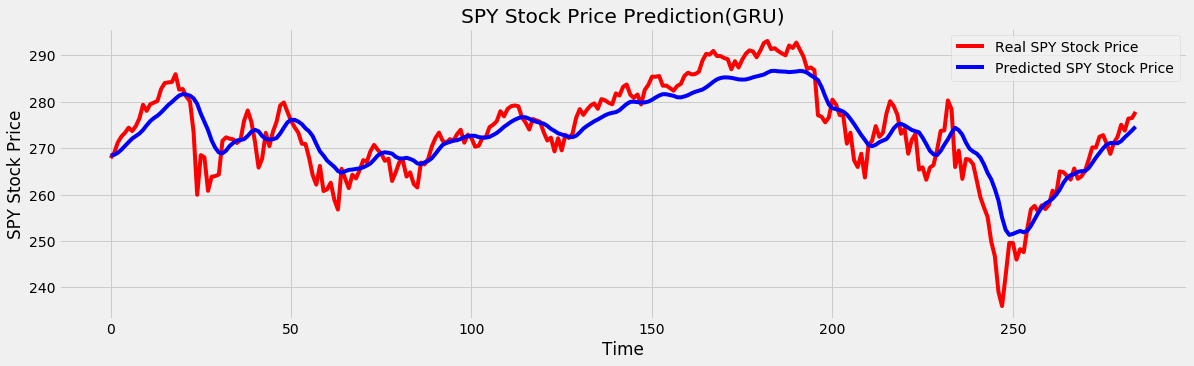

In [92]:
# testing the model
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inp=inputs
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(previous,len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


####################################################
print(test_set[-1],predicted_stock_price[-1])
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+share+ ' Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+share+' Stock Price')
plt.title(share+' Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel(share+' Stock Price')
plt.legend()
plt.show()

In [95]:
inp

array([[259.040009],
       [258.589996],
       [258.519989],
       [260.200012],
       [260.149994],
       [260.480011],
       [260.75    ],
       [262.899994],
       [263.630005],
       [266.049988],
       [265.309998],
       [266.799988],
       [265.149994],
       [263.730011],
       [264.429993],
       [265.519989],
       [266.380005],
       [267.320007],
       [267.559998],
       [267.220001],
       [267.040009],
       [268.600006],
       [268.529999],
       [268.329987],
       [268.390015],
       [267.640015],
       [267.440002],
       [267.730011],
       [267.920013],
       [268.549988],
       [268.809998],
       [270.640015],
       [272.160004],
       [273.559998],
       [274.100006],
       [275.25    ],
       [274.420013],
       [276.119995],
       [278.109985],
       [280.089996],
       [280.049988],
       [279.959991],
       [280.410004],
       [282.690002],
       [283.619995],
       [284.700012],
       [284.269989],
       [286.6

In [89]:
# regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

# training_set = dataset['2014':'2017'].iloc[:,0:1].values  #2010 or 2012
# test_set = dataset['2019':].iloc[:,0:1].values

import pandas as pd


# predicted_stock_price = regressorGRU.predict(X_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# loss_and_metrics = regressorGRU.evaluate(x_test, y_test, batch_size=128)
classes = regressorGRU.predict(test_set, batch_size=128)



# plt.plot(dataset_total)
# dataset["Close"].plot(figsize=(16,4),legend=True)
# plt.show()

ValueError: Error when checking input: expected gru_5_input to have 3 dimensions, but got array with shape (285, 1)

[277.809998] [285.84686]


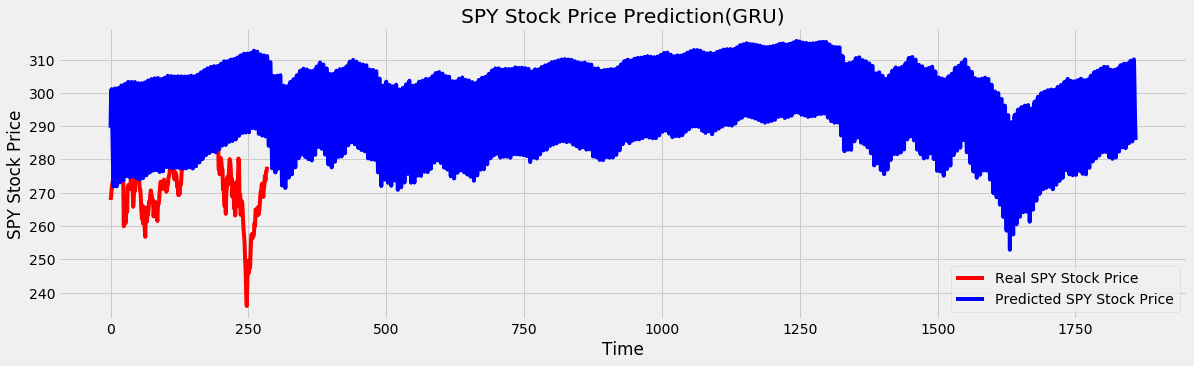

In [65]:
####################################################
print(test_set[-1],predicted_stock_price[-1])
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+share+ ' Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+share+' Stock Price')
plt.title(share+' Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel(share+' Stock Price')
plt.legend()
plt.show()